In [23]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, Dropout
from keras.applications.xception import Xception
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import sklearn.metrics as metrics

import numpy as np
import pandas as pd

import pickle
import sys, gc, os
import glob

import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
d=128

In [3]:
# https://keras.io/examples/cifar10_resnet/
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [4]:
le = LabelEncoder()

train = np.empty(shape=(0,d,d,3), dtype=np.int8)
labels = np.empty(shape=(0,2), dtype=np.float)

for f in glob.glob("../data/train_Xception_*"):
    print(f)
    train_loader = np.load(f)
    fakes = train_loader['fakes']
    train = np.append(train,fakes,axis=0)
    print('fakes',len(fakes))
    reals = train_loader['reals']
    train = np.append(train,reals,axis=0)
    print('reals',len(reals))
    l = np.append(np.full(len(fakes),'FAKE'),np.full(len(reals),'REAL'))
    l = le.fit_transform(l)
    l = np_utils.to_categorical(l, 2)
    print('labels',labels.ndim,l.ndim)
    labels = np.append(labels,l,axis=0)
    
print('train=',len(train))
print('labels',len(labels))

../data/train_Xception_1.npz
fakes 2919
reals 2880
labels 2 2
train= 5799
labels 5799


In [5]:
# Input image dimensions.
input_shape = train[1].shape
print(input_shape)
num_classes=2
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200



(128, 128, 3)


In [28]:
def Xception1():
    image_input = Input(shape=(d,d,3))
    
    cnn = Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling='avg')(image_input)

    d1 = Dense(512)(cnn)
    d1 = Dropout(0.5)(d1)
  
    output = Dense(2, activation='softmax')(d1)
    
    model = Model(inputs=image_input, outputs=output)

    return model

In [29]:
model = Xception1()


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

# Prepare model model saving directory.
save_dir = '../models'
model_name = 'DDC_Xception_model.{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.2,
                               cooldown=0,
                               patience=2,
                               min_lr=0.5e-6)

earlystop = EarlyStopping(monitor='val_loss',
                          patience=6)

callbacks = [checkpoint, lr_reducer, lr_scheduler, earlystop]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_11 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 1026      
Total params: 21,911,594
Trainable params: 21,857,066
Non-trainable params: 54,528
_________________________________________________________________


In [30]:
(trainX, testX, trainY, testY) = train_test_split(train, labels, test_size=0.25, random_state=42)

In [ ]:
del train, labels

In [31]:
history = model.fit(trainX,
              trainY,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(testX, testY),
              shuffle=True,
              callbacks=callbacks)

Train on 4349 samples, validate on 1450 samples
Epoch 1/200
Learning rate:  0.001
4349/4349 [==============================] - 924s 212ms/step - loss: 0.7006 - acc: 0.4934 - val_loss: 0.6927 - val_acc: 0.5255

Epoch 00001: val_loss improved from inf to 0.69267, saving model to ../models/DDC_Xception_model.001.h5
Epoch 2/200
Learning rate:  0.001
4349/4349 [==============================] - 900s 207ms/step - loss: 0.6939 - acc: 0.4875 - val_loss: 0.6932 - val_acc: 0.4745

Epoch 00002: val_loss did not improve from 0.69267
Epoch 3/200
Learning rate:  0.001
4349/4349 [==============================] - 897s 206ms/step - loss: 0.6940 - acc: 0.5093 - val_loss: 0.7803 - val_acc: 0.5359

Epoch 00003: val_loss did not improve from 0.69267
Epoch 4/200
Learning rate:  0.001
4349/4349 [==============================] - 901s 207ms/step - loss: 0.6961 - acc: 0.5024 - val_loss: 0.6921 - val_acc: 0.4745

Epoch 00004: val_loss improved from 0.69267 to 0.69213, saving model to ../models/DDC_Xception_mod

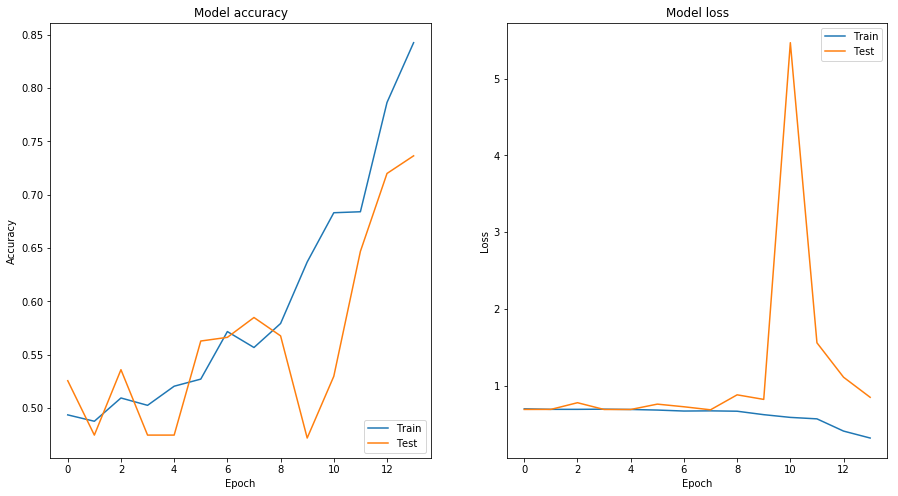

In [33]:
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 8))

# Plot training & validation accuracy values
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('Model accuracy')
ax1.set(xlabel="Epoch", ylabel="Accuracy")
ax1.legend(['Train', 'Test'], loc='lower right')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(xlabel="Epoch", ylabel="Loss")
ax2.legend(['Train', 'Test'], loc='upper right')

plt.show()

In [35]:
predictions = model.predict(testX)

In [38]:
metrics.log_loss(testY[:,0],predictions[:,0])

0.8820946913429394